In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/local-bert/config.json
/kaggle/input/local-bert/tokenizer.json
/kaggle/input/local-bert/tokenizer_config.json
/kaggle/input/local-bert/pytorch_model.bin
/kaggle/input/local-bert/special_tokens_map.json
/kaggle/input/local-bert/vocab.txt
/kaggle/input/local-bert/flax_model.msgpack.download/flax_model.msgpack.download/flax_model.msgpack
/kaggle/input/local-bert/model.onnx.download/model.onnx.download/model.onnx
/kaggle/input/local-bert/rust_model.ot.download/rust_model.ot.download/rust_model.ot
/kaggle/input/local-bert/tf_model.h5.download/tf_model.h5.download/tf_model.h5
/kaggle/input/local-bert/model.safetensors.download/model.safetensors.download/model.safetensors
/kaggle/input/mistral-datasets/Mistral7B_CME_v3.csv
/kaggle/input/m

Importing Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
snowball = SnowballStemmer(language='english')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as XGB
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading the datasets

In [3]:
# Load the datasets
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')

In [4]:
dataset_1_loc ='/kaggle/input/mistral-datasets/Mistral7B_CME_v6.csv'
aug_data1 = pd.read_csv(dataset_1_loc)
aug_data1 = aug_data1[aug_data1["prompt_id"]==2]
aug_data1["prompt_id"]=aug_data1['prompt_id']-2
aug_data1

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4195,0,The concept of car-free cities is becoming in...,Car-free cities,1
4196,0,Car-free cities: a vision for a healthier and...,Car-free cities,1
4197,0,The concept of car-free cities has gained pop...,Car-free cities,1
4198,0,Car-free cities are cities where cars are not...,Car-free cities,1


In [5]:
dataset_2_loc = '/kaggle/input/mistral-datasets/Mistral7B_CME_v7.csv'
aug_data2 = pd.read_csv(dataset_2_loc)
aug_data2 = aug_data2[aug_data2["prompt_id"]==12]
aug_data2["prompt_id"]=aug_data2['prompt_id']-11
aug_data2

,prompt_id,text,prompt_name,generated
4200,1,The electoral college is a system that is use...,Does the electoral college work?,1
4201,1,The electoral college system that is used to ...,Does the electoral college work?,1
4202,1,The electoral college is a system used in the...,Does the electoral college work?,1
4203,1,The electoral college is a system in which ci...,Does the electoral college work?,1
4204,1,The Electoral College is a system used in the...,Does the electoral college work?,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [6]:
aug_data_mistral = pd.concat([aug_data1,aug_data2],axis=0)
aug_data_mistral

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [7]:
aug_data_mistral = aug_data_mistral.drop(columns= ['prompt_name'])
aug_data_mistral

,prompt_id,text,generated
3500,0,Car-free cities are becoming increasingly pop...,1
3501,0,Car-free cities are becoming increasingly pop...,1
3502,0,Car-free cities are becoming increasingly pop...,1
3503,0,Car-free cities have become increasingly popu...,1
3504,0,Car-free cities are a growing concept in toda...,1
...,...,...,...
4895,1,The electoral college is one of the most disc...,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",1
4897,1,The electoral college is a system that is use...,1
4898,1,A strong electoral system is vital to the fun...,1


In [8]:
train_csv= train_essays.drop(columns=['id'])
train_csv

,prompt_id,text,generated
0,0,Cars. Cars have been around since they became ...,0
1,0,Transportation is a large necessity in most co...,0
2,0,"""America's love affair with it's vehicles seem...",0
3,0,How often do you ride in a car? Do you drive a...,0
4,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...
1373,1,There has been a fuss about the Elector Colleg...,0
1374,0,Limiting car usage has many advantages. Such a...,0
1375,0,There's a new trend that has been developing f...,0
1376,0,As we all know cars are a big part of our soci...,0


In [9]:
final_data = pd.concat([train_csv,aug_data_mistral],axis=0)
final_data

,prompt_id,text,generated
0,0,Cars. Cars have been around since they became ...,0
1,0,Transportation is a large necessity in most co...,0
2,0,"""America's love affair with it's vehicles seem...",0
3,0,How often do you ride in a car? Do you drive a...,0
4,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...
4895,1,The electoral college is one of the most disc...,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",1
4897,1,The electoral college is a system that is use...,1
4898,1,A strong electoral system is vital to the fun...,1


([<matplotlib.patches.Wedge at 0x7937e6a343a0>,
 [Text(0.017414888503137493, 1.0998621375692608, 'generated by AI'),
  Text(-0.017414991479663147, -1.0998621359387564, 'not generated by AI')],
 [Text(0.00949903009262045, 0.5999248023105058, '49.50%'),
  Text(-0.009499086261634442, -0.5999248014211398, '50.50%')])

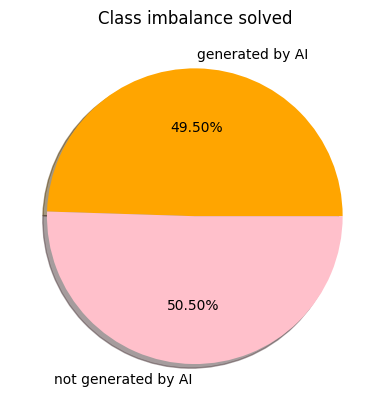

In [10]:
classes = final_data.groupby('generated').count()['text']
plt.title('Class imbalance solved')
plt.pie(classes, labels=['generated by AI','not generated by AI'],colors=['orange','pink'],shadow=True,autopct='%0.2f%%')

In [11]:
final_data['text'].index = np.arange(0,2778)
final_data['text']

0       Cars. Cars have been around since they became ...
1       Transportation is a large necessity in most co...
2       "America's love affair with it's vehicles seem...
3       How often do you ride in a car? Do you drive a...
4       Cars are a wonderful thing. They are perhaps o...
                              ...                        
2773     The electoral college is one of the most disc...
2774     Dear Sen. [Name],\n\nI am writing to express ...
2775     The electoral college is a system that is use...
2776     A strong electoral system is vital to the fun...
2777     The electoral college is a system used in the...
Name: text, Length: 2778, dtype: object

In [ ]:
stemtext = []
len_text = []
para = final_data['text'].tolist()
for paragraph in para:
    char = [char for char in paragraph if char not in string.punctuation]
    word = "".join(char).split(" ")
    words = [word.lower() for word in word if word not in stopwords.words('english')]
    stemwords = [SnowballStemmer('english').stem(word) for word in words]
    len_text.append(len(stemwords))
    stemtext.append(" ".join(stemwords))

In [ ]:
final_data['text']=stemtext
final_data

In [ ]:
test_data = test_essays
train_data = final_data

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# Path to the local directory containing tokenizer files
local_bert_directory = '/kaggle/input/local-bert/'

# Initialize the tokenizer from the local directory
tokenizer = BertTokenizer.from_pretrained(local_bert_directory)

# Initialize the tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EssayDataset(Dataset):
    def __init__(self, essays, targets, tokenizer, max_len):
        self.essays = essays
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, item):
        essay = str(self.essays[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'essay_text': essay,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

# Define max token length
MAX_LEN = 256

# Create the dataset
train_dataset = EssayDataset(
    essays=train_data['text'].to_numpy(),
    targets=train_data['generated'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)


In [ ]:
from transformers import BertForSequenceClassification
import torch

# Path where the model directory was transferred
transferred_model_directory = '/kaggle/input/model-bert/'

# Load the model
model = BertForSequenceClassification.from_pretrained(transferred_model_directory)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from transformers import AdamW
from torch.utils.data import DataLoader

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# DataLoader
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
from tqdm import tqdm

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
EPOCHS = 2

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
train_data, val_data = train_test_split(train_essays, test_size=0.1)

# Create datasets for training and validation
train_dataset = EssayDataset(
    essays=train_data['text'].to_numpy(),
    targets=train_data['generated'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = EssayDataset(
    essays=val_data['text'].to_numpy(),
    targets=val_data['generated'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create data loaders
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluate the model
val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
)

print(f'Validation loss {val_loss}, accuracy {val_acc}')

In [ ]:
class TestEssayDataset(Dataset):
    def __init__(self, essays, tokenizer, max_len):
        self.essays = essays
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, item):
        essay = str(self.essays[item])

        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'essay_text': essay,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Create the test dataset
test_dataset = TestEssayDataset(
    essays=test_essays['text'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# DataLoader for the test data
test_data_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Predicting on test data
model.eval()
test_predictions = []
with torch.no_grad():
    for d in test_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        test_predictions.extend(preds.tolist())

# Prepare submission file
sample_submission = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
sample_submission['generated'] = test_predictions
sample_submission.to_csv('submission.csv', index=False)